In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')
#plt.rcParams["figure.dpi"] = 600
from sklearn.model_selection import train_test_split

In [2]:
corder = ['C1', 'C2', 'C3', 'C4', 'C0']

In [3]:
morder = ['MIN', 'OVERFLOW', 'MIXOTROPH', 'EXOENZYME', 'ROS',]
media_order = ['lowN', 'pro99']
mpalette = 'twilight'
sns.color_palette(mpalette, n_colors=5)

[(0.4828677867260272, 0.6304330455306234, 0.761915371498953),
 (0.3668108554010799, 0.26404857724525643, 0.6464799165290824),
 (0.18488035509396164, 0.07942573027972388, 0.21307651648984993),
 (0.5566322903496934, 0.17269677158182117, 0.31423043195101424),
 (0.775907907306857, 0.5355421788246119, 0.42413367909988375)]

In [4]:
gorder = [ 'Strong', 'Sustained', 'Weak', 'Inhibited','Axenic', 'Other']
gpalette = sns.color_palette('Set2', n_colors=4).as_hex() + ['black', 'lightgrey']
sns.color_palette(gpalette)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.0, 0.0, 0.0),
 (0.8274509803921568, 0.8274509803921568, 0.8274509803921568)]

In [16]:
df_predicted_classes = pd.read_csv('monte_add_het_predicted_classes.csv.gz')

In [17]:
df = df_predicted_classes.loc[df_predicted_classes.model.isin(['ROS'])].reset_index()

In [18]:
df.columns

Index(['index', 'run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which',
       'model', 'hash', 'VPRO', 'Unnamed: 0', 'Sample', 'full name', 'Group',
       'RMSE_Bptotal[N]', 'RMSE_Bptotal[C]', 'compare_points', 'RMSE',
       'RMSE_filled'],
      dtype='object')

In [19]:
df.head()

,index,run_id,y_pred,max_prob,idx,media,which,model,hash,VPRO,Unnamed: 0,Sample,full name,Group,RMSE_Bptotal[N],RMSE_Bptotal[C],compare_points,RMSE,RMSE_filled
0,27637,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1010_...,Strong,0.980199,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1010_32,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_1010,439986.0,5x5_21A0,A. macleodii ATCC27126,Strong,17.890132,166.356304,74.0,2976.136153,2976.136153
1,27638,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1021_...,Strong,0.979711,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1021_69,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_1021,527346.0,5x5_21A0,A. macleodii ATCC27126,Strong,19.779328,164.212354,74.0,3248.009977,3248.009977
2,27639,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1034_...,Other,0.992864,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1034_27,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,27640,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1050_...,Other,0.992872,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1050_36,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_1050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,27641,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1056_...,Strong,0.919534,monteadd_ROS_100_monte_vpro_19_33_ROS_C0_1056_2,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_1056,355006.0,5x5_21B0,A. macleodii ATCC27126,Strong,22.107876,162.621239,74.0,3595.210249,3595.210249


In [20]:
df['RMSE'] = np.sqrt(df['RMSE'])

In [21]:
df.shape

(9880, 19)

In [22]:
df[['Group']].value_counts().reset_index()

,Group,count
0,Strong,2866
1,Weak,2790
2,Axenic,740
3,Sustained,140
4,Inhibited,3


In [23]:
df[['Group','model']].value_counts().reset_index()

,Group,model,count
0,Strong,ROS,2866
1,Weak,ROS,2790
2,Axenic,ROS,740
3,Sustained,ROS,140
4,Inhibited,ROS,3


In [25]:
df[['y_pred', 'full name']].value_counts()

y_pred     full name                     
Strong     A. macleodii ATCC27126            2841
Weak       Marinovum 5F3                     2416
Axenic     Axenic                             740
Weak       Roseovarius 5C3                    374
Sustained  Sulfitobacter pseudonitzschiae      72
           Ruegeria pomeroyi                   68
Strong     Pseudoalteromonas haloplanktis      25
Inhibited  Marinobacter adhaerens HP15          2
           Phaeobacter gallaeciensis            1
Name: count, dtype: int64

In [26]:
df['RMSE'].describe()

count    6539.000000
mean       35.901894
std        21.746794
min         1.391959
25%        14.977285
50%        26.478415
75%        58.506834
max        82.487376
Name: RMSE, dtype: float64

In [27]:
df.nlargest(10, 'RMSE')

,index,run_id,y_pred,max_prob,idx,media,which,model,hash,VPRO,Unnamed: 0,Sample,full name,Group,RMSE_Bptotal[N],RMSE_Bptotal[C],compare_points,RMSE,RMSE_filled
6167,33804,monteadd_ROS_66_monte_vpro_19_33_ROS_C0_386_57...,Strong,0.980667,monteadd_ROS_66_monte_vpro_19_33_ROS_C0_386_57,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_386,539943.0,5x5_21A0,A. macleodii ATCC27126,Strong,24.884038,273.435019,74.0,82.487376,6804.167268
7641,35278,monteadd_ROS_7_monte_vpro_19_33_ROS_C0_40_6_lo...,Strong,0.986960,monteadd_ROS_7_monte_vpro_19_33_ROS_C0_40_6,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_40,420096.0,5x5_21A0,A. macleodii ATCC27126,Strong,23.802617,274.499573,74.0,80.831975,6533.808134
6223,33860,monteadd_ROS_67_monte_vpro_19_33_ROS_C0_1010_9...,Strong,0.982645,monteadd_ROS_67_monte_vpro_19_33_ROS_C0_1010_9,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_1010,383241.0,5x5_21A0,A. macleodii ATCC27126,Strong,23.166194,277.314803,74.0,80.151910,6424.328602
8100,35737,monteadd_ROS_84_monte_vpro_19_33_ROS_C0_1010_7...,Strong,0.980666,monteadd_ROS_84_monte_vpro_19_33_ROS_C0_1010_75,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_1010,627381.0,5x5_21A0,A. macleodii ATCC27126,Strong,23.168553,276.683228,74.0,80.064662,6410.350087
3212,30849,monteadd_ROS_39_monte_vpro_19_33_ROS_C0_40_14_...,Strong,0.980660,monteadd_ROS_39_monte_vpro_19_33_ROS_C0_40_14,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_40,638340.0,5x5_21A0,A. macleodii ATCC27126,Strong,23.569967,271.607715,74.0,80.011154,6401.784768
8213,35850,monteadd_ROS_85_monte_vpro_19_33_ROS_C0_19_26_...,Strong,0.981345,monteadd_ROS_85_monte_vpro_19_33_ROS_C0_19_26,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_19,389598.0,5x5_21A0,A. macleodii ATCC27126,Strong,23.460064,269.282379,74.0,79.481958,6317.381713
4786,32423,monteadd_ROS_53_monte_vpro_19_33_ROS_C0_386_77...,Strong,0.980659,monteadd_ROS_53_monte_vpro_19_33_ROS_C0_386_77,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_386,336714.0,5x5_21A0,A. macleodii ATCC27126,Strong,24.026554,261.779205,74.0,79.307327,6289.652192
1389,29026,monteadd_ROS_22_monte_vpro_19_33_ROS_C0_1010_2...,Strong,0.980664,monteadd_ROS_22_monte_vpro_19_33_ROS_C0_1010_26,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_1010,396384.0,5x5_21A0,A. macleodii ATCC27126,Strong,22.781177,272.079456,74.0,78.729222,6198.290323
4208,31845,monteadd_ROS_48_monte_vpro_19_33_ROS_C0_386_17...,Strong,0.981340,monteadd_ROS_48_monte_vpro_19_33_ROS_C0_386_17,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_386,551175.0,5x5_21A0,A. macleodii ATCC27126,Strong,23.814556,257.249184,74.0,78.270525,6126.275039
4583,32220,monteadd_ROS_51_monte_vpro_19_33_ROS_C0_287_85...,Strong,0.987411,monteadd_ROS_51_monte_vpro_19_33_ROS_C0_287_85,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0_287,336363.0,5x5_21A0,A. macleodii ATCC27126,Strong,23.102633,264.299521,74.0,78.140992,6106.014709


In [28]:
df['RMSE_clip'] = df.RMSE.clip(upper=100)

In [29]:
df.pivot_table(index='model', columns='Group', values='run_id', aggfunc='count', fill_value=0).reindex(index=morder, columns=gorder[:-1])

Group,Strong,Sustained,Weak,Inhibited,Axenic
model,,,,,
MIN,NaN,NaN,NaN,NaN,NaN
OVERFLOW,NaN,NaN,NaN,NaN,NaN
MIXOTROPH,NaN,NaN,NaN,NaN,NaN
EXOENZYME,NaN,NaN,NaN,NaN,NaN
ROS,2866.0,140.0,2790.0,3.0,740.0


In [30]:
pdf = df.pivot_table(index='model', columns='y_pred', values='run_id', aggfunc='count', fill_value=0).reindex(index=morder, columns=gorder)
pdf

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
model,,,,,,
MIN,NaN,NaN,NaN,NaN,NaN,NaN
OVERFLOW,NaN,NaN,NaN,NaN,NaN,NaN
MIXOTROPH,NaN,NaN,NaN,NaN,NaN,NaN
EXOENZYME,NaN,NaN,NaN,NaN,NaN,NaN
ROS,2866.0,140.0,2790.0,3.0,740.0,3341.0


In [31]:
pdf.div(pdf.sum(axis=1), axis=0) *100

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
model,,,,,,
MIN,NaN,NaN,NaN,NaN,NaN,NaN
OVERFLOW,NaN,NaN,NaN,NaN,NaN,NaN
MIXOTROPH,NaN,NaN,NaN,NaN,NaN,NaN
EXOENZYME,NaN,NaN,NaN,NaN,NaN,NaN
ROS,29.008097,1.417004,28.238866,0.030364,7.489879,33.815789


In [32]:
df.groupby(['model', 'VPRO']).y_pred.unique().str.join(',').reset_index().groupby(['model','y_pred']).size()

model  y_pred                               
ROS    Axenic,Other,Strong,Weak,Inhibited        1
       Axenic,Other,Weak                         1
       Axenic,Weak                               6
       Axenic,Weak,Other                         2
       Other,Axenic,Strong,Sustained,Weak        1
       Other,Axenic,Strong,Weak                  2
       Other,Axenic,Sustained,Strong,Weak        1
       Other,Axenic,Sustained,Weak               1
       Other,Axenic,Weak                         7
       Other,Axenic,Weak,Strong                  1
       Other,Axenic,Weak,Strong,Sustained        1
       Other,Strong                              1
       Other,Strong,Axenic                       3
       Other,Strong,Axenic,Sustained,Weak        1
       Other,Strong,Axenic,Weak                  2
       Other,Strong,Axenic,Weak,Sustained        2
       Other,Strong,Sustained                    1
       Other,Strong,Sustained,Axenic             1
       Other,Strong,Sustained,Axenic,

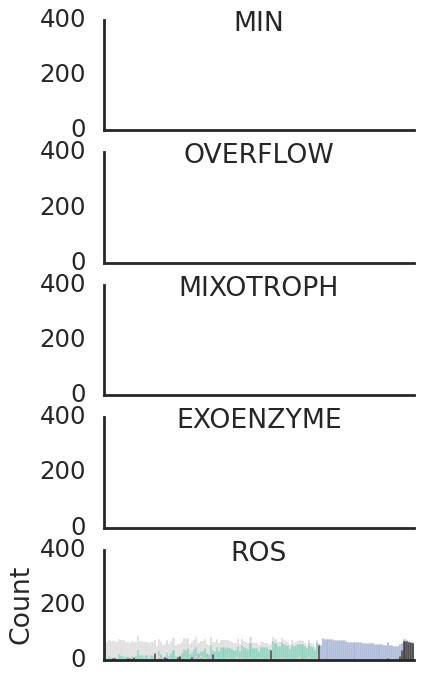

In [33]:
fig, axs = plt.subplots(5, sharey=True, figsize=(5,10))
for i,m in enumerate(morder):
        t = df.loc[
            df.model.isin([m]) #& df.VPRO_cluster.isin([c])
            #df.Group.isin(glist)
        ].copy()
        if t.shape[0]>0:
            tnumdf = t.pivot_table(
                index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
            ).reindex(columns=[ 'Axenic','Weak',  'Sustained','Strong',   'Inhibited','Other', ])
            #tnumdf['total'] = tnumdf.sum(axis=1)        
            tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
            t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))
            g = sns.histplot(
                data=t, lw=0.3,
                hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
                hue_order=[gorder[-1]] + gorder[:-1], palette=[gpalette[-1]] + gpalette[:-1],
                ax=axs[i], 
                #aspect=1,
                legend=False,
                       )
        axs[i].set_xticks([])
        axs[i].set_yticks([0,200,400])
        axs[i].set_xlabel('')
        axs[i].set_title(m, y=0.85)
        sns.despine()
            #g.set(xticklabels=[])
            #g.set_titles(col_template='{col_name}', row_template='{row_name}')
            #axs[i,j].set_title(f'{m} {c}')
plt.show()


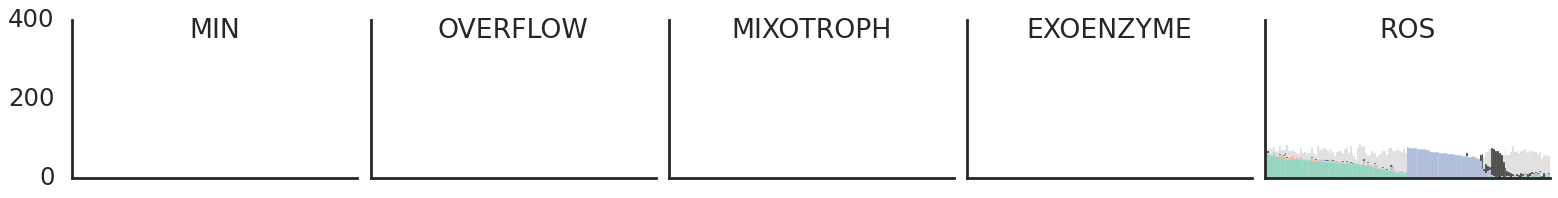

In [34]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(20,3))
for i,m in enumerate(morder):
        t = df.loc[
            df.model.isin([m]) #& df.VPRO_cluster.isin([c])
            #df.Group.isin(glist)
        ].copy()
        if t.shape[0]>0:
            tnumdf = t.pivot_table(
                index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
            )
            tnumdf = tnumdf.clip(lower=10)
            tnumdf = tnumdf.reindex(columns=gorder)
            tnumdf = tnumdf.sort_values(by=list(tnumdf.columns.to_list()), ascending=False)
            t['VPRO_'] = pd.Categorical(t['VPRO'], tnumdf.index)
            g = sns.histplot(
                data=t, lw=0.3,
                hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
                #hue_order=[gorder[-1]] + gorder[:-1], palette=[gpalette[-1]] + gpalette[:-1],
                hue_order=reversed(gorder), palette=reversed(gpalette),
                ax=axs[i], 
                #aspect=1,
                legend=False,
                       )
        axs[i].set_xticks([])
        axs[i].set_yticks([0,200,400])
        axs[i].set_xlabel('')
        axs[i].set_title(m, y=0.85)
            #g.set(xticklabels=[])
            #g.set_titles(col_template='{col_name}', row_template='{row_name}')
            #axs[i,j].set_title(f'{m} {c}')
        sns.despine()
fig.tight_layout(w_pad=0.5) # Or equivalently,  "plt.tight_layout()"            
plt.show()


In [35]:
tnumdf

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
VPRO,,,,,,
vpro_19_33_ROS_C0_81,60,10,10,10,10,15
vpro_19_33_ROS_C0_227,60,10,10,10,10,10
vpro_19_33_ROS_C0_641,58,10,10,10,10,15
vpro_19_33_ROS_C0_728,57,10,10,10,10,13
vpro_19_33_ROS_C0_1060,56,10,10,10,10,14
...,...,...,...,...,...,...
vpro_19_33_ROS_C0_979,10,10,10,10,10,46
vpro_19_33_ROS_C0_1034,10,10,10,10,10,45
vpro_19_33_ROS_C0_565,10,10,10,10,10,45


In [36]:
for i,m in enumerate(morder):
    t = df.loc[
        df.model.isin([m]) 
    ].copy()
    if t.shape[0]>0:
        tnumdf = t.pivot_table(
            index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
        ).reindex(columns=gorder)
        #tnumdf['total'] = tnumdf.sum(axis=1)        
        tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
        t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))


In [37]:
tnumdf

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
VPRO,,,,,,
vpro_19_33_ROS_C0_966,0,0,49,0,0,0
vpro_19_33_ROS_C0_876,0,0,51,0,0,0
vpro_19_33_ROS_C0_321,0,0,52,0,0,0
vpro_19_33_ROS_C0_219,0,0,54,0,0,0
vpro_19_33_ROS_C0_458,0,0,54,0,0,0
...,...,...,...,...,...,...
vpro_19_33_ROS_C0_444,0,1,2,0,9,57
vpro_19_33_ROS_C0_385,11,1,2,0,0,58
vpro_19_33_ROS_C0_344,3,1,2,0,4,58


In [38]:
df.loc[df.Group.isin(['Strong','Sustained', 'Inhibited'])].VPRO.value_counts().nlargest(30)

VPRO
vpro_19_33_ROS_C0_227     63
vpro_19_33_ROS_C0_81      63
vpro_19_33_ROS_C0_1060    63
vpro_19_33_ROS_C0_641     59
vpro_19_33_ROS_C0_1010    59
vpro_19_33_ROS_C0_728     58
vpro_19_33_ROS_C0_340     58
vpro_19_33_ROS_C0_1094    57
vpro_19_33_ROS_C0_772     56
vpro_19_33_ROS_C0_78      56
vpro_19_33_ROS_C0_263     56
vpro_19_33_ROS_C0_287     55
vpro_19_33_ROS_C0_19      52
vpro_19_33_ROS_C0_40      52
vpro_19_33_ROS_C0_932     51
vpro_19_33_ROS_C0_934     50
vpro_19_33_ROS_C0_1021    50
vpro_19_33_ROS_C0_166     50
vpro_19_33_ROS_C0_660     49
vpro_19_33_ROS_C0_759     49
vpro_19_33_ROS_C0_912     48
vpro_19_33_ROS_C0_32      47
vpro_19_33_ROS_C0_417     47
vpro_19_33_ROS_C0_817     46
vpro_19_33_ROS_C0_653     45
vpro_19_33_ROS_C0_980     45
vpro_19_33_ROS_C0_386     45
vpro_19_33_ROS_C0_353     43
vpro_19_33_ROS_C0_424     43
vpro_19_33_ROS_C0_26      43
Name: count, dtype: int64

In [40]:
# get a list of high growth VPROs
VPRO_lst = df.loc[df.y_pred.isin(['Strong','Sustained', 'Inhibited'
                                 # 'Other'
                                 ]),['model','VPRO']].value_counts().reset_index()

VPRO_lst = VPRO_lst.rename(columns={0: 'count'})
VPRO_lst = VPRO_lst.loc[VPRO_lst['count'].ge(5)]
#VPRO_lst['VPRO'].to_csv('../VPRO/high_growing_vpro.csv', index=False)
VPRO_lst.model.value_counts()
VPRO_lst

,model,VPRO,count
0,ROS,vpro_19_33_ROS_C0_1060,63
1,ROS,vpro_19_33_ROS_C0_227,63
2,ROS,vpro_19_33_ROS_C0_81,63
3,ROS,vpro_19_33_ROS_C0_1010,59
4,ROS,vpro_19_33_ROS_C0_641,59
...,...,...,...
80,ROS,vpro_19_33_ROS_C0_1056,7
81,ROS,vpro_19_33_ROS_C0_66,7
82,ROS,vpro_19_33_ROS_C0_565,6
83,ROS,vpro_19_33_ROS_C0_295,6


In [42]:
for m in ['ROS']:
    VPRO_lst.loc[VPRO_lst.model.isin([m]),'VPRO'].to_csv(f'../VPRO/high_growing_vpro_round2_{m}.csv', index=False, header=False)
    